In [4]:
import os, gc, glob, random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import keras
from PIL import Image
from keras.layers import Dense,Flatten
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from os import listdir


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dirName = '/content/drive/MyDrive/IBM/Digital Naturalist Dataset/Augmented Dataset'
folders = listdir(dirName)

def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for fol_name in listOfFile:
        fullPath = os.path.join(dirName,fol_name)
        allFiles.append(fullPath)
    return allFiles

Folders = getListOfFiles(dirName)
len(Folders)
subfolders = []
for num in range(len(Folders)):
    sub_fols = getListOfFiles(Folders[num])
    subfolders+=sub_fols


In [8]:
subfolders

['/content/drive/MyDrive/IBM/Digital Naturalist Dataset/Augmented Dataset/Mammals/SW_Deer_AUG',
 '/content/drive/MyDrive/IBM/Digital Naturalist Dataset/Augmented Dataset/Mammals/LS_Pangolin_AUG',
 '/content/drive/MyDrive/IBM/Digital Naturalist Dataset/Augmented Dataset/Flowers/LS_Orchid_AUG',
 '/content/drive/MyDrive/IBM/Digital Naturalist Dataset/Augmented Dataset/Flowers/Corpse_AUG',
 '/content/drive/MyDrive/IBM/Digital Naturalist Dataset/Augmented Dataset/Birds/SPS_AUG',
 '/content/drive/MyDrive/IBM/Digital Naturalist Dataset/Augmented Dataset/Birds/GIB_AUG']

In [10]:
X_data=[]
Y_data=[]
id_no=0

found=[]

for paths in subfolders:
    files = glob.glob(paths + "/*.jpg")

    for myFile in files:
        img=Image.open(myFile)
        img=img.resize((224,224),Image.ANTIALIAS)
        img=np.array(img)
        if img.shape==(224,224,3):
            X_data.append(img)
            Y_data.append(id_no)
    id_no+=1

In [12]:

X=np.array(X_data)
Y=np.array(Y_data)

X=X.astype('float32')/255.0
y_cat=to_categorical(Y_data,len(subfolders))


X_train,X_test,y_train,y_test=train_test_split(X,y_cat,test_size=0.2)
print("The model has "+str(len(X_train))+" inputs")

The model has 2703 inputs


In [13]:
#importing inceptionV3 a pretrained model
base_model = InceptionV3(input_shape=(224,224,3),include_top=False)

87910968/87910968 [==============================] - 1s 0us/step


In [14]:
#setting the weights learnt by the pretrained model to false to halt learning
for layer in base_model.layers:
  layer.trainable = False

In [15]:
#flattening the output layer from the pretrained model
basemodel_output = Flatten()(base_model.output)
basemodel_output = Dense(units = 6, activation = 'sigmoid')(basemodel_output)

In [16]:
nn_model = Model(base_model.input,basemodel_output)
nn_model.compile(optimizer = 'adam',loss = keras.losses.binary_crossentropy,metrics=['accuracy'])


In [17]:
nn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [18]:
# Creating a model checkpoint which monitors the accuracy of the model and saves the checkpoint
mc = ModelCheckpoint(filepath = "./model.h5",
                     monitor = 'accuracy',
                     verbose = 1,
                     save_best_only = True)

# Creating a earlystopping object which stop training once the model performance stops improving on a hold out validation dataset
es = EarlyStopping(monitor = "accuracy",
                   min_delta = 0.01,
                   verbose = 1)

call_back = [mc,es]

In [20]:
history = nn_model.fit(X_train,y_train, steps_per_epoch=60,epochs = 30,callbacks=call_back,validation_data=(X_test,y_test))

Epoch 1/30
60/60 [==============================] - ETA: 0s - loss: 0.3992 - accuracy: 0.9040
Epoch 1: accuracy improved from -inf to 0.90397, saving model to ./model.h5
60/60 [==============================] - 364s 6s/step - loss: 0.3992 - accuracy: 0.9040 - val_loss: 0.0126 - val_accuracy: 0.9970
Epoch 2/30
60/60 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 0.9989
Epoch 2: accuracy improved from 0.90397 to 0.99891, saving model to ./model.h5
60/60 [==============================] - 358s 6s/step - loss: 0.0058 - accuracy: 0.9989 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 2: early stopping


In [21]:
# Exporting the model to json 
model_json = nn_model.to_json()
with open("DigitalNaturalist.json", "w") as json_file:
    json_file.write(model_json)

# Exporting the model weights

nn_model.save_weights("DigitalNaturalist")
print("Saved model to disk")

Saved model to disk


1/1 [==============================] - 0s 335ms/step


"Lady's slipper orchid"

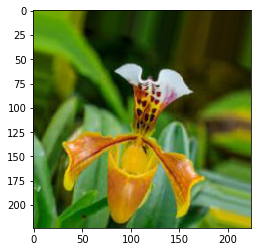

In [31]:
#Model Evaluation
predictions = ["Corpse Flower", 
               "Great Indian Bustard", 
               "Lady's slipper orchid", 
               "Pangolin", 
               "Spoon Billed Sandpiper", 
               "Seneca White Deer"
              ]


path = '/content/drive/MyDrive/IBM/Digital Naturalist Dataset/Augmented Dataset/Flowers/LS_Orchid_AUG/aug_download (1)_0_4894.jpg'
ime = tf.keras.utils.load_img(path,target_size=(224,224))

i = tf.keras.preprocessing.image.img_to_array(ime)
i = preprocess_input(i)
input = np.array([i])
pred = nn_model.predict(input)
plt.imshow(ime)
predictions[np.argmax(pred)]